In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls

2024-04-28 16:30:38.266370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 16:30:38.266483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 16:30:38.382463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/50
  2/312 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.1328 - loss: 4.9608  

W0000 00:00:1714363035.001733     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/312 ━━━━━━━━━━━━━━━━━━━━ 2:39 580ms/step - accuracy: 0.1474 - loss: 7.8446

W0000 00:00:1714363055.224497     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.3516 - loss: 3.0006

W0000 00:00:1714363197.008632     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 183s 535ms/step - accuracy: 0.3521 - loss: 2.9964 - val_accuracy: 0.6401 - val_loss: 1.0383
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5625 - loss: 0.9936 - val_accuracy: 0.6250 - val_loss: 1.5488
Epoch 3/50


W0000 00:00:1714363204.607802     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 159s 499ms/step - accuracy: 0.6689 - loss: 0.9700 - val_accuracy: 0.6593 - val_loss: 0.8693
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.7269 - val_accuracy: 0.8750 - val_loss: 0.2133
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 156s 489ms/step - accuracy: 0.7362 - loss: 0.7660 - val_accuracy: 0.7369 - val_loss: 0.7653
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.6562 - loss: 0.8576 - val_accuracy: 0.3750 - val_loss: 2.0814
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 156s 491ms/step - accuracy: 0.7571 - loss: 0.6906 - val_accuracy: 0.7218 - val_loss: 0.7993
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.8750 - loss: 0.4956 - val_accuracy: 0.7500 - val_loss: 0.6416
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 494ms/step - accuracy: 0.7726 - loss: 0.6417 - val_accuracy: 0.7671 - val_loss: 0.6800
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.8750 - loss: 0.4035 - val_

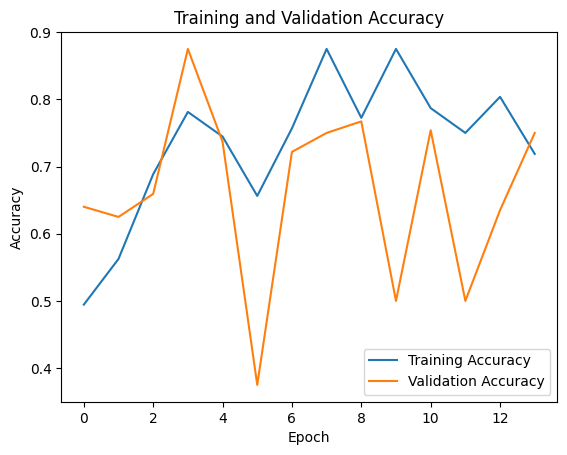

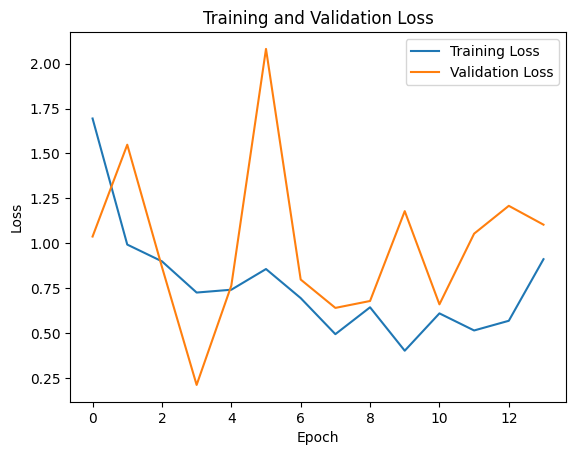

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Define directories
train_dir = "/kaggle/input/tomatoleaf/tomato/train"
val_dir = "/kaggle/input/tomatoleaf/tomato/val"
class_names = sorted(os.listdir(train_dir))

# Define parameters
batch_size = 32
image_shape = (224, 224)
epochs = 50

# Define data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint callback to save the best model
checkpoint_filepath = '/kaggle/working/best_model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Define early stopping callback to prevent overfitting
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

# Print the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
